# Example 01: Understanding the Data Pipeline

In Example 00, `create_dls_silverbox` handled everything behind the scenes:
downloading data, creating sliding windows, splitting into train/validation
sets, and normalizing inputs. This example reveals what is actually happening
under the hood. You will learn how to use the general-purpose `create_dls`
function directly, inspect the benchmark specification, and understand how
TSFast normalizes your data.

## Prerequisites

- [Example 00: Your First Model](00_your_first_model.ipynb)

## Setup

In [1]:
import identibench as idb

from tsfast.datasets import create_dls
from tsfast.datasets.benchmark import create_dls_silverbox
from tsfast.models.rnn import RNNLearner

## The Convenience Wrapper

In Example 00, we loaded data with a single call to `create_dls_silverbox()`.
This is a convenience wrapper that pre-fills all the benchmark-specific
parameters (column names, dataset path, download URL) from the IdentiBench
benchmark specification. Let's create the same DataLoaders again.

In [2]:
dls_convenience = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)

## Inspecting the Benchmark Specification

Every IdentiBench benchmark has a specification object that defines the input
and output column names, the dataset download path, and other metadata. Let's
look at the Silverbox specification.

In [3]:
spec = idb.BenchmarkSilverbox_Simulation
print(f"Input columns:  {spec.u_cols}")
print(f"Output columns: {spec.y_cols}")
print(f"Dataset path:   {spec.dataset_path}")

Input columns:  ['u0']
Output columns: ['y0']
Dataset path:   /home/pheenix/.identibench_data/silverbox


## Building the DataLoaders Explicitly

Now let's call `create_dls` directly, passing the same parameters that the
convenience wrapper fills in for us. This gives you full control over every
aspect of the data pipeline.

Parameters explained:

- **`u`** -- list of input signal column names in the HDF5 files. These are
  the signals that drive the system (e.g., voltage applied to a circuit).
- **`y`** -- list of output signal column names. These are the signals the
  model learns to predict (e.g., the circuit's response).
- **`dataset`** -- path to the dataset directory, which must contain `train/`,
  `valid/`, and optionally `test/` subdirectories with HDF5 files.
- **`win_sz`** -- window size: how many consecutive time steps make up one
  training sample.
- **`stp_sz`** -- step size: the stride between consecutive windows. A smaller
  step size creates more overlapping windows and more training samples.
- **`bs`** -- batch size: number of windows per training step.
- **`n_batches_train`** -- fixed number of training batches per epoch. This
  ensures consistent training time regardless of the total number of windows
  in the dataset. Windows are sampled randomly each epoch.

In [4]:
dls_explicit = create_dls(
    u=spec.u_cols,
    y=spec.y_cols,
    dataset=spec.dataset_path,
    win_sz=500,
    stp_sz=10,
    bs=16,
    n_batches_train=300,
)

## Inspecting the Data

`show_batch` visualizes random windows from the training set. The bottom
subplot shows the input signal(s), and the upper subplot(s) show the output
signal(s) that the model will learn to predict.

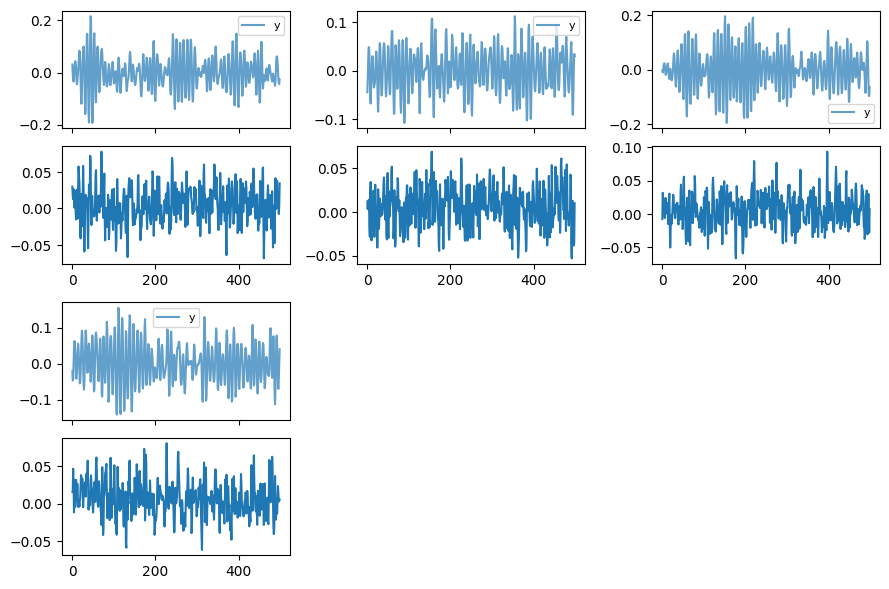

In [5]:
dls_explicit.show_batch(max_n=4)

## Normalization

By default, TSFast normalizes **input signals only** using z-score
normalization (subtract the mean, divide by the standard deviation). Output
signals remain in their **original physical units**, which means model
predictions are directly interpretable without any inverse transformation.

The normalization statistics computed from the training set are stored in
`dls.norm_stats`.

In [6]:
print("Input normalization:")
print(f"  Mean: {dls_explicit.norm_stats.u.mean}")
print(f"  Std:  {dls_explicit.norm_stats.u.std}")
print()
print("Output normalization:")
print(f"  Mean: {dls_explicit.norm_stats.y.mean}")
print(f"  Std:  {dls_explicit.norm_stats.y.std}")

Input normalization:
  Mean: [0.00619542]
  Std:  [0.0222824]

Output normalization:
  Mean: [0.00084752]
  Std:  [0.05468483]


## Training with the Explicit Pipeline

Let's train the same LSTM model from Example 00 using our explicitly-built
DataLoaders. The result should be comparable.

In [7]:
lrn = RNNLearner(dls_explicit, rnn_type='lstm')
lrn.fit_flat_cos(n_epoch=5)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.006924,0.005776,0.010615,00:04
1,0.005172,0.006486,0.011133,00:03
2,0.004742,0.004567,0.009846,00:03
3,0.005789,0.004185,0.009771,00:03
4,0.003000,0.002967,0.009485,00:03


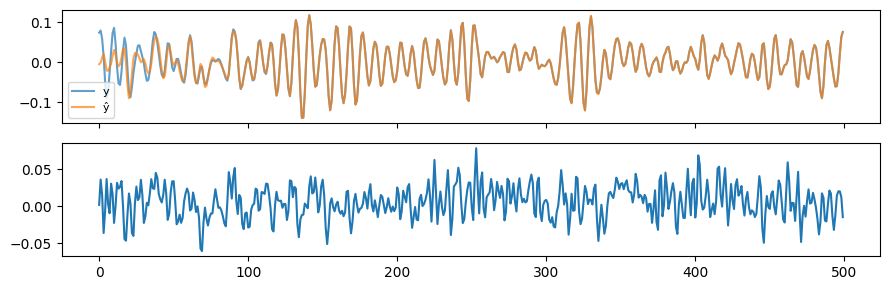

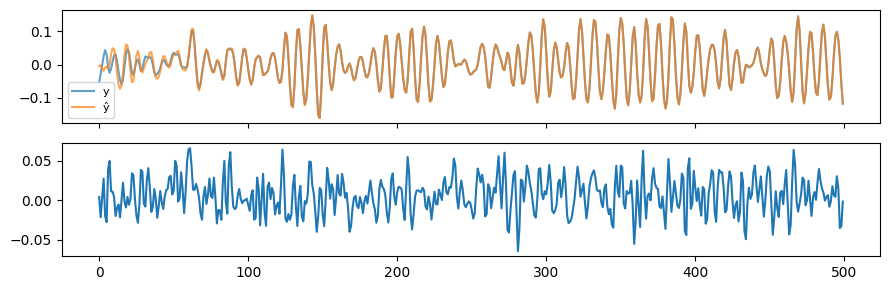

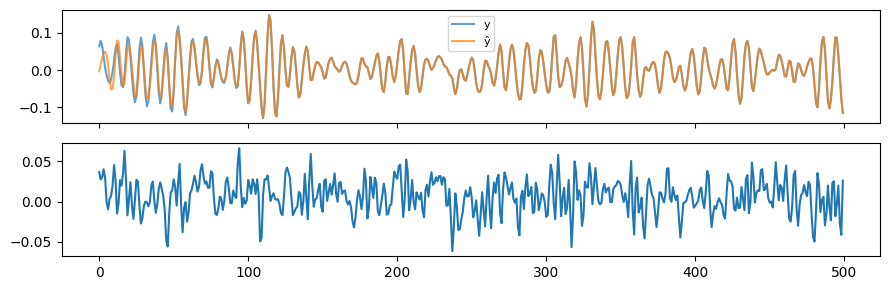

In [8]:
lrn.show_results(max_n=3)

## Key Takeaways

- **`create_dls_silverbox`** is a convenience wrapper around `create_dls` with
  pre-filled benchmark parameters (column names, dataset path, download
  function).
- **`create_dls`** is the general-purpose factory: it loads HDF5 files,
  extracts sliding windows with configurable size (`win_sz`) and stride
  (`stp_sz`), and splits the data by directory structure
  (`train/`/`valid/`/`test/`).
- **Inputs are normalized** (z-score), while **outputs stay in physical
  units** so that predictions are directly interpretable.
- **`dls.norm_stats`** stores the computed normalization statistics, accessible
  as `.u` (inputs) and `.y` (outputs).
- **`n_batches_train`** fixes the number of training batches per epoch,
  decoupling training time from dataset size.